## Setup

Import the necessary libraries.

In [1]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import json

The hidden code cell limits the output height in colab.

In [2]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [4]:
from google.cloud import storage
import io
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/ralf/.config/gcloud/application_default_credentials.json"
os.environ['GOOGLE_CLOUD_PROJECT'] = "359515640875"
client = storage.Client()
bucket = client.get_bucket('06fff4a5ff3c1cb7a4089a63899047ff8dcd')
# Then do other things...
blob1 = bucket.get_blob('ROTVRSV')
blob2 = bucket.get_blob('DENV')
in_memory_file1 = io.BytesIO()
blob1.download_to_file(in_memory_file1)
in_memory_file1.seek(0)
in_memory_file2 = io.BytesIO()
blob2.download_to_file(in_memory_file2)
in_memory_file2.seek(0)

0

In [5]:
# Load the dataset
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd

# Assuming your dataset is stored in a CSV file
dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"

trds = pd.read_json(in_memory_file1,
                 dtype={"preprocessedText": str, "label": str},
                lines=True
                 )
teds = pd.read_json(in_memory_file2,
                 dtype={"preprocessedText": str, "label": str},
                lines=True
                 )
tr_ds = tfdf.keras.pd_dataframe_to_tf_dataset(trds, label="label")
te_ds = tfdf.keras.pd_dataframe_to_tf_dataset(teds, label="label")

with open(dataset_path + "DENV") as file:
    test_lines = file.readlines()

In [25]:
def prepare_dataset1(example, label):
    return {"sentence" : example["preprocessedText"]}, label

def prepare_dataset2(s):
    m = json.loads(s)
#    sp = tf.strings.split(m["originalTitle"])
#    print(sp)
#    m["prep"] = tf.RaggedTensor.from_tensor(sp, ragged_rank=1)
#    m["prep"] = tf.constant(sp)
    return m

train_ds = tr_ds.map(prepare_dataset1)
test_ds = te_ds.map(prepare_dataset1)
#for features, label in test_ds:
#    print("features:", features)
#    print("label:", label)
#    break
    
test_cases = list(map(prepare_dataset2, test_lines))

In [32]:
#%set_cell_height 300

import tensorflow_hub as hub
# NNLM (https://tfhub.dev/google/nnlm-en-dim128/2) is also a good choice.
# hub_url = "http://tfhub.dev/google/universal-sentence-encoder/4"
embedding = hub.KerasLayer("/home/ralf//models/universal-sentence-encoder_4")

sentence = tf.keras.layers.Input(shape=(), name="sentence", dtype=tf.string)
embedded_sentence = embedding(sentence)

raw_inputs = {"sentence": sentence}
processed_inputs = {"embedded_sentence": embedded_sentence}
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

model_2 = tfdf.keras.RandomForestModel(
    preprocessing=preprocessor,
    num_trees=500)

model_2.fit(x=train_ds)

ValueError: in user code:

    /home/ralf/.local/lib/python3.6/site-packages/tensorflow_hub/keras_layer.py:242 call  *
        result = smart_cond.smart_cond(training,
    /home/ralf/.local/lib/python3.6/site-packages/tensorflow/python/saved_model/load.py:664 _call_attribute  **
        return instance.__call__(*args, **kwargs)
    /home/ralf/.local/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:885 __call__
        result = self._call(*args, **kwds)
    /home/ralf/.local/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:933 _call
        self._initialize(args, kwds, add_initializers_to=initializers)
    /home/ralf/.local/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:760 _initialize
        *args, **kwds))
    /home/ralf/.local/lib/python3.6/site-packages/tensorflow/python/eager/function.py:3066 _get_concrete_function_internal_garbage_collected
        graph_function, _ = self._maybe_define_function(args, kwargs)
    /home/ralf/.local/lib/python3.6/site-packages/tensorflow/python/eager/function.py:3463 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    /home/ralf/.local/lib/python3.6/site-packages/tensorflow/python/eager/function.py:3308 _create_graph_function
        capture_by_value=self._capture_by_value),
    /home/ralf/.local/lib/python3.6/site-packages/tensorflow/python/framework/func_graph.py:1007 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /home/ralf/.local/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:668 wrapped_fn
        out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    /home/ralf/.local/lib/python3.6/site-packages/tensorflow/python/saved_model/function_deserialization.py:294 restored_function_body
        "\n\n".join(signature_descriptions)))

    ValueError: Could not find matching function to call loaded from the SavedModel. Got:
      Positional arguments (3 total):
        * Tensor("inputs:0", shape=(None,), dtype=string)
        * False
        * None
      Keyword arguments: {}
    
    Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (3 total):
        * {'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'), 'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
        * False
        * None
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (3 total):
        * {'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids'), 'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'), 'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids')}
        * True
        * None
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (3 total):
        * {'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids'), 'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask')}
        * False
        * None
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (3 total):
        * {'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'), 'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids')}
        * True
        * None
      Keyword arguments: {}


In [29]:
model_2.compile(metrics=["accuracy"])
evaluation = model_2.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

136/136 [==============================] - 3s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8486
BinaryCrossentropyloss: 0.0
Accuracy: 0.8486000895500183


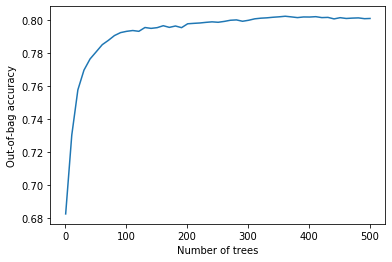

In [30]:
import matplotlib.pyplot as plt

logs = model_2.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

In [31]:
p = model_2.predict(test_ds)

#Fish for best cut
for cut in np.arange(0.25, .8, .05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    N = len(p)
    for i in range(N):
        tru = test_cases[i]["label"] == '1'
        prd = p[i] > cut
        if tru and prd == tru:
            tp = tp + 1
        if tru and prd != tru:
            fn = fn + 1
        if tru == False and prd == tru:
            tn = tn + 1
        if tru == False and prd != tru:
            fp = fp + 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("cut: {}, acc: {}, prec: {}, rec: {}, f1: {}".format(cut, (tp+tn)/N, precision, recall, f1_score))

cut: 0.25, acc: 0.688328148404194, prec: 0.45179465776293826, rec: 0.9652251448952296, f1: 0.6154939587775409
cut: 0.3, acc: 0.7408687636824519, prec: 0.49929444967074316, rec: 0.9465002229157379, f1: 0.6537336412625097
cut: 0.35, acc: 0.7844221684525867, prec: 0.5495471497069793, rec: 0.9197503343736068, f1: 0.688010672002668
cut: 0.39999999999999997, acc: 0.8154165226408573, prec: 0.5976836330387078, rec: 0.8742755238519839, f1: 0.7099927588703839
cut: 0.44999999999999996, acc: 0.8338518262472635, prec: 0.640182009100455, rec: 0.8154257690592955, f1: 0.7172549019607842
cut: 0.49999999999999994, acc: 0.8486000691323885, prec: 0.6885911490052781, rec: 0.756130182790905, f1: 0.7207819804504887
cut: 0.5499999999999999, acc: 0.8502131581979491, prec: 0.7330696984676224, rec: 0.6611680784663397, f1: 0.695264885138303
cut: 0.5999999999999999, acc: 0.8509044820831894, prec: 0.792, rec: 0.5737851092287115, f1: 0.6654601861427094
cut: 0.6499999999999999, acc: 0.8420324922226063, prec: 0.839035

In [210]:
cut = 55
N = len(p)
with open("/home/ralf//IdeaProjects/LitBall-training/pred.json", "w") as file:
    for i in range(N):
        tru = test_cases[i]["label"] == '1'
        val = int((p[i]+0.005) * 100)
        pred = False
        if val > cut:
            pred = True
        if tru != pred:
            m = {"DOI": test_cases[i]["DOI"], "pred": pred, "val": val}
            file.write(json.dumps(m))
            file.write("\n")